[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\ragha\AppData\Local\Temp\ipykernel_18332\2388585313.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train.append(data[symbol]['Scaled Close'][i])


Epoch 1/25


C:\Users\ragha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 - 7s - 73ms/step - loss: 0.0070
Epoch 2/25
101/101 - 5s - 46ms/step - loss: 0.0013
Epoch 3/25
101/101 - 5s - 46ms/step - loss: 0.0014
Epoch 4/25
101/101 - 5s - 46ms/step - loss: 0.0012
Epoch 5/25
101/101 - 5s - 47ms/step - loss: 0.0011
Epoch 6/25
101/101 - 5s - 47ms/step - loss: 0.0012
Epoch 7/25
101/101 - 5s - 46ms/step - loss: 0.0011
Epoch 8/25
101/101 - 5s - 47ms/step - loss: 0.0014
Epoch 9/25
101/101 - 5s - 48ms/step - loss: 0.0011
Epoch 10/25
101/101 - 5s - 46ms/step - loss: 0.0010
Epoch 11/25
101/101 - 4s - 44ms/step - loss: 9.5694e-04
Epoch 12/25
101/101 - 5s - 46ms/step - loss: 7.6738e-04
Epoch 13/25
101/101 - 5s - 45ms/step - loss: 9.1424e-04
Epoch 14/25
101/101 - 5s - 45ms/step - loss: 7.4121e-04
Epoch 15/25
101/101 - 5s - 46ms/step - loss: 7.6040e-04
Epoch 16/25
101/101 - 5s - 47ms/step - loss: 7.3249e-04
Epoch 17/25
101/101 - 5s - 46ms/step - loss: 7.0008e-04
Epoch 18/25
101/101 - 4s - 44ms/step - loss: 7.4542e-04
Epoch 19/25
101/101 - 5s - 46ms/step - loss: 6.3693e

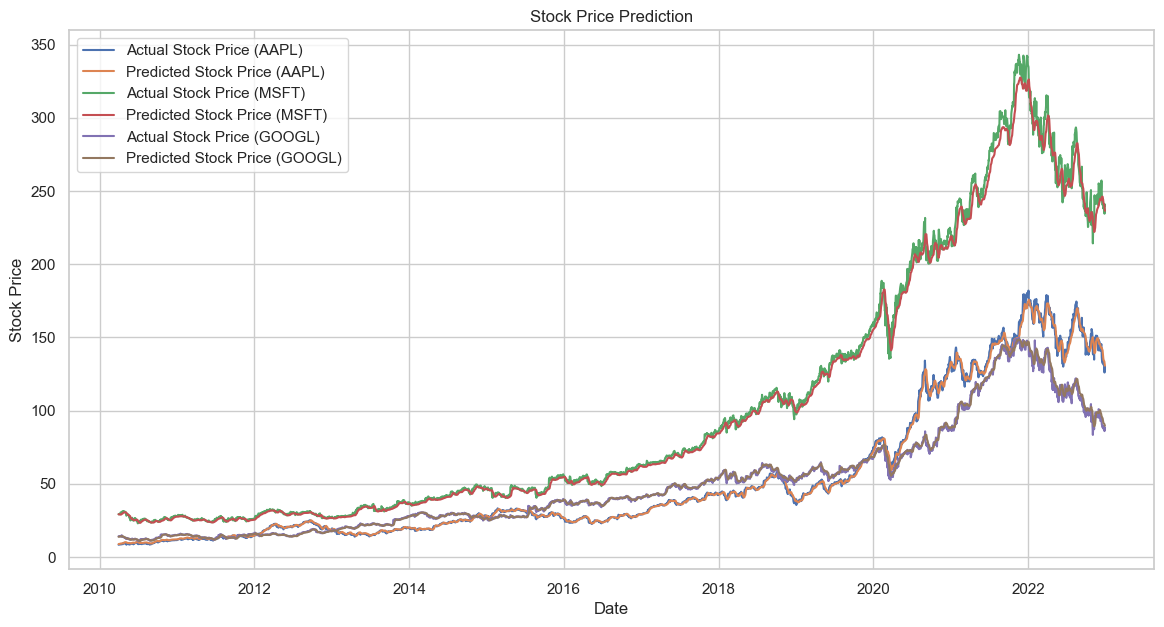

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


SystemExit: 1

C:\Users\ragha\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from bayes_opt import BayesianOptimization
import logging
import os
import time
from flask import Flask, request, jsonify


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


stock_symbols = ['AAPL', 'MSFT', 'GOOGL']  # You can change this to any stock symbols
start_date = '2010-01-01'
end_date = '2023-01-01'

data = {}
for symbol in stock_symbols:
    data[symbol] = yf.download(symbol, start=start_date, end=end_date)


scalers = {}
for symbol in stock_symbols:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[symbol]['Close'].values.reshape(-1, 1))
    scalers[symbol] = scaler
    data[symbol]['Scaled Close'] = scaled_data


sequence_length = 60
X_train_all = {}
y_train_all = {}

for symbol in stock_symbols:
    X_train = []
    y_train = []
    for i in range(sequence_length, len(data[symbol])):
        X_train.append(data[symbol]['Scaled Close'][i-sequence_length:i])
        y_train.append(data[symbol]['Scaled Close'][i])
    X_train_all[symbol] = np.array(X_train)
    y_train_all[symbol] = np.array(y_train)


models = {}
for symbol in stock_symbols:
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_all[symbol].shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
    model.fit(X_train_all[symbol], y_train_all[symbol], epochs=25, batch_size=32, callbacks=[early_stopping], verbose=2)
    
    models[symbol] = model

predictions = {}
for symbol in stock_symbols:
    predictions[symbol] = models[symbol].predict(X_train_all[symbol])
    predictions[symbol] = scalers[symbol].inverse_transform(predictions[symbol])


sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
for symbol in stock_symbols:
    plt.plot(data[symbol].index[sequence_length:], data[symbol]['Close'][sequence_length:], label=f'Actual Stock Price ({symbol})')
    plt.plot(data[symbol].index[sequence_length:], predictions[symbol], label=f'Predicted Stock Price ({symbol})')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        request_data = request.json
        symbol = request_data['symbol']
        X_test = request_data['X_test']
        model = models[symbol]
        scaler = scalers[symbol]
        if model is not None:
            predictions = model.predict(np.array(X_test).reshape(1, -1, 1))
            predictions = scaler.inverse_transform(predictions)
            return jsonify({'predictions': predictions.tolist()})
        else:
            return jsonify({'error': f"Model not found for {symbol}"})
    except Exception as e:
        logger.error(f"Error predicting for symbol {symbol}: {e}")
        return jsonify({'error': f"Error predicting for symbol {symbol}: {e}"}), 500

if __name__ == "__main__":
    app.run(debug=True)
